# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q paired with embedPy to carry out machine learning tasks. Below we show how to dimensionality reduction can be used to produce a better dataset for a chosen machine learning model. Data from the MNIST Database has been used throughout this notebook.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## EmbedPy

EmbedPy allows the kdb+/q interpreter to manipulate Python objects, call Python functions and load Python libraries. Python and kdb+/q developers can fuse both technologies together, allowing for a seamless application of kdb+/q’s high-speed analytics and Python’s rich ecosystem of libraries such as scikit-learn, Tensorflow, PyTorch and Theano.

## Dimensionality Reduction

Dimensionality reduction is the process of reducing the number of features in a dataset, while preserving as much information as possible.

Two main techniques of dimensionality reduction are:
- **Feature selection**: finding the best subset of the features.
- **Feature extraction**: transforming the data from high-to-low-dimensional space.

By finding a lower-dimensional representation, we reduce the size of the dataset and can improve both the efficiency and accuracy of machine learning models. It is also easier to visualize data in very low dimensions (i.e. 2D or 3D), making dimensionality reduction an important tool in exploratory data analysis and inference.

Further discussion of dimensionality reduction can be found on the Wikipedia article [Dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction).

## MNIST (handwritten digits) database

The [Modified National Institute of Standards and Technology (MNIST) Database](https://keras.io/datasets/), is a large collection of handwritten digits.

MNIST is commonly used for training and testing image processing systems, particularly in the field of machine learning.

---

### Load data

In the cell below, we load in the utilities library from the kdb+/q [ML-Toolkit](https://github.com/KxSystems/ml), along with graphics functions required for this notebook. We then use embedPy to import relevant python modules and load data from the MNIST database.

In [1]:
/ load toolkit and graphics functions
\l ml/ml.q
.ml.loadfile`:util/init.q
\l ../utils/graphics.q
\l ../utils/util.q

In [2]:
/ load data and split into training/testing sets
mnist:.p.import[`keras.datasets.mnist][`:load_data;<][]
data:raze(`xtrain`ytrain;`xtest`ytest)!'mnist
data:@[data;`xtrain`xtest;%;255]
data:@[data;`ytrain`ytest;"f"$]

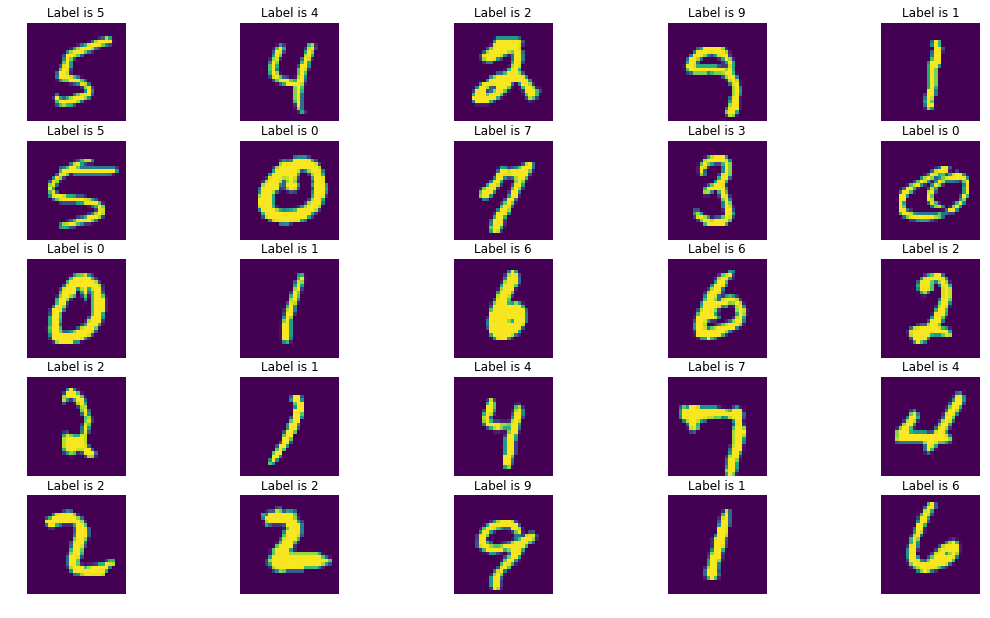

In [3]:
/ plot a random sample of digits
subplots:plt[`:subplots][5;5]
fig:subplots[@;0]
axarr:subplots[@;1]
fig[`:set_size_inches;18.5;10.5];

{ i:rand count data`xtest;
  box:axarr[`$":__getitem__"].p.eval","sv string x;
  box[`:imshow]"f"$data[`xtest]i;
  box[`:axis]`off;
  box[`:set_title]"Label is ",string data[`ytest]i;
 }each cross[til 5;til 5];

plt[`:show][];

---

### Principal Components Analysis

Principal Components Analysis (PCA) is the main linear technique for dimensionality reduction. PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized.

The covariance (or correlation) matrix of the data is constructed, the eigen-decomposition is computed and the eigenvectors corresponding to the largest eigenvalues are selected. These vectors, known as the Principal Components, are used as a basis for the original data.

This process reduced the dimension of the dataspace with some data loss, but retaining the majority of the variance.

In [4]:
PCA:.p.import[`sklearn.decomposition;`:PCA][`n_components pykw 2;`whiten pykw 1b]
-1"Results of PCA\n";
show resPCA:PCA[`:fit_transform][`X pykw npa raze each data`xtest]`
-1"\nShape: "," x "sv string .ml.shape resPCA;

Results of PCA

-0.6998554 -1.348291 
0.09881115 1.930832  
-1.591294  0.9015564 
2.136803   -0.2101584
0.2261381  -1.462161 
-1.723457  1.038942  
-0.5990965 -1.066074 
-0.6049166 -0.618651 
0.4347603  -0.3838363
-0.1126741 -1.576254 
1.799294   1.064056  
0.5706664  0.3258694 
-0.4019423 -1.92322  
1.709511   -0.1556516
-1.496254  0.8887186 
0.07639534 0.7805042 
0.1467301  -1.799439 
-0.1703749 -1.203364 
0.08249856 0.7406141 
-0.5177532 -1.311782 
-0.6922699 -0.7458996
0.3461343  0.07208687
..

Shape: 10000 x 2


#### Visualize PCA

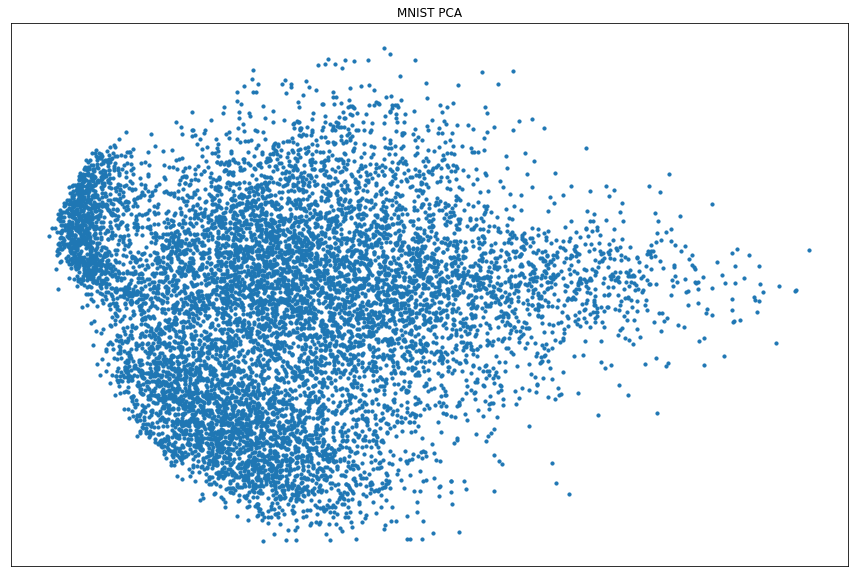

In [5]:
subplots:plt[`:subplots][]

fig:subplots[@;0]
fig[`:set_figheight]10;
fig[`:set_figwidth]15;

axarr:subplots[@;1]
axarr[`:set_title]"MNIST PCA";
axarr[`:scatter][resPCA[;0];resPCA[;1];`s pykw 10];
plt[;*;()]each`:xticks`:yticks;
plt[`:show][];

#### Visualise PCA (checking with labels)

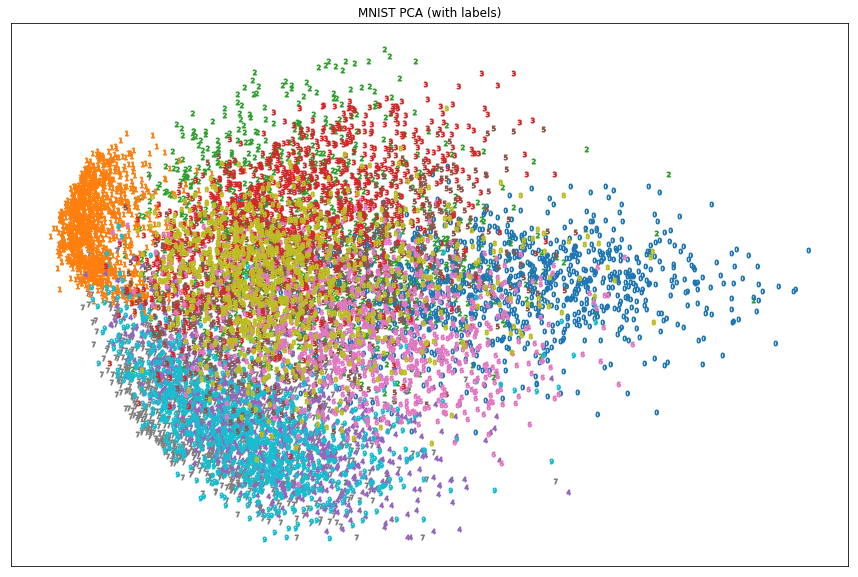

In [6]:
subplots:plt[`:subplots][]

fig:subplots[@;0]
fig[`:set_figheight]10;
fig[`:set_figwidth]15;

axarr:subplots[@;1]
axarr[`:set_title]"MNIST PCA (with labels)";
{i:where data[`ytest]=x;
 axarr[`:scatter][resPCA[i;0];resPCA[i;1];`s pykw 25;`c pykw"C",string x;`marker pykw"$",string[x],"$"]
 }each distinct data`ytest;
plt[;()]each`:xticks`:yticks;
plt[`:show][];

---

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-distributed stochastic neighbor embedding (t-SNE) is a ML algorithm for nonlinear dimensionality reduction. Each high-dimensional point is transformed to a point in 2D or 3D space, such that similar points are close and dissimilar points are distant.

The t-SNE algorithm is comprised of two stages:
- Constructs a probability distribution over pairs of high-dimensional objects so that similar objects have a high probability, while dissimilar points have a small probability.
- Construct a probability distribution over points in the low-dimensional map and minimize the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the map. 

t-SNE is often used to visualize high-level representations of data, such as those learned by an artificial neural network.

In [7]:
manifold:.p.import`sklearn.manifold
tsne:manifold[`:TSNE;`n_components pykw 2;`init pykw `pca;`verbose pykw 2]

t0:.z.t
-1"Running t-SNE\n";
-1"This algorithm is computationally expensive please allow ample time to execute (Expected execution time = 4/5mins)!\n";
resTSNE:tsne[`:fit_transform;npa raze each data`xtest]`

-1"\nResults of t-SNE\n";
show resTSNE;
-1"\nShape: "," x "sv string .ml.shape resTSNE;
-1"\nCalculation time:",string (.z.t-t0);

Running t-SNE

This algorithm is computationally expensive please allow ample time to execute (Expected execution time = 4/5mins)!

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.386s...
[t-SNE] Computed neighbors for 10000 samples in 170.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.030838
[t-SNE] Computed condit

#### Visualise t-SNE

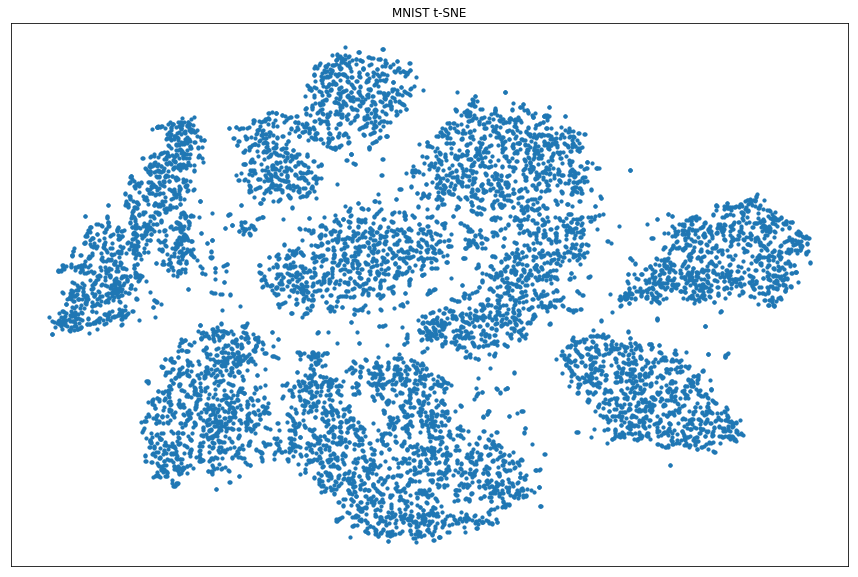

In [8]:
subplots:plt[`:subplots][]

fig:subplots[@;0]
fig[`:set_figheight]10;
fig[`:set_figwidth]15;

axarr:subplots[@;1]
axarr[`:set_title]"MNIST t-SNE";
axarr[`:scatter;resTSNE[;0];resTSNE[;1];`s pykw 10];
plt[;()]each`:xticks`:yticks;
plt[`:show][];

#### Visualise t-SNE (checking with labels)

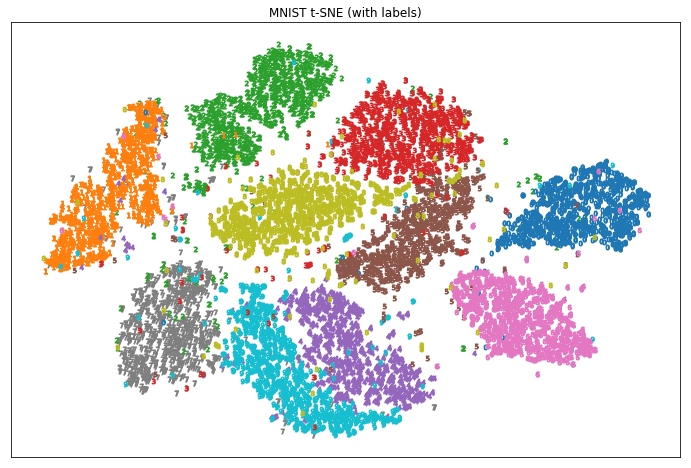

In [9]:
subplots:plt[`:subplots][]

fig:subplots[@;0]
fig[`:set_figheight]8;
fig[`:set_figwidth]12;

axarr:subplots[@;1]
axarr[`:set_title]"MNIST t-SNE (with labels)";
{i:where data[`ytest]=x;axarr[`:scatter;resTSNE[i;0];resTSNE[i;1];`s pykw 25;`c pykw"C",string x;`marker pykw"$",string[x],"$"]}each distinct data`ytest;
plt[;()]each`:xticks`:yticks;
plt[`:show][];

---